# DS Challenge

**Please Note: This collaborative notebook includes the work of multiple contributors.**

Here we examine the [Wisconsin breast cancer dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data). The goal is to build a model that predicts whether a given biopsied sample is **benign** or **malignant**. This is a binary classification problem.

## Load Modules, Dataset

In [110]:
!pip install imbalanced-learn

    100% |████████████████████████████████| 153kB 2.0MB/s ta 0:00:01
distributed 1.21.8 requires msgpack, which is not installed.


Let's begin by loading the dataset and seeing how it looks!

In [168]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

In [169]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Our dataset has **nine features**, as well as an extraneous 'id' column and a 'class' column which is 2 for benign samples and 4 for malignant samples. 

In [170]:
# load dataset
df = pd.read_csv('/Users/meldye/Documents/Insight/18B/data_challenge_1/breast-cancer-wisconsin.csv', names=['id', 'clump_thickness', 'uniformity_size', 'uniformity_shape', 'marg_adhesion', 'epithelial_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class'])
df.head()

,id,clump_thickness,uniformity_size,uniformity_shape,marg_adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Let's drop ```df['id']``` now, since it takes up space and will not be used in the analysis.

In [171]:
# drop the id column
df = df.drop(columns='id')

The 2 and 4 that we have in ```df['class']``` are non-standard values to use for binary classification. Let's change them to 0 (benign) and 1 (malignant).

In [172]:
# convert classes to 0: benign, 1: malignant
df['class'] = df['class'].replace({2: 0, 4: 1})

## Examine Data

Now, let's assess the rest of the data...

In [173]:
# examine metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
clump_thickness     699 non-null int64
uniformity_size     699 non-null int64
uniformity_shape    699 non-null int64
marg_adhesion       699 non-null int64
epithelial_size     699 non-null int64
bare_nuclei         699 non-null object
bland_chromatin     699 non-null int64
normal_nucleoli     699 non-null int64
mitoses             699 non-null int64
class               699 non-null int64
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


The spec says that each feature should range from 1-10, and that appears to be true at first glance. However, the ```bare_nuclei``` column is missing from ```df.describe()```.

In [174]:
# print overview of features, class
df.describe()

,clump_thickness,uniformity_size,uniformity_shape,marg_adhesion,epithelial_size,bland_chromatin,normal_nucleoli,mitoses,class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,0.344778
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.475636
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


## Impute Missing Values

Let's do a more careful search for missing data.

In [175]:
# first pass
df.isnull().sum()

clump_thickness     0
uniformity_size     0
uniformity_shape    0
marg_adhesion       0
epithelial_size     0
bare_nuclei         0
bland_chromatin     0
normal_nucleoli     0
mitoses             0
class               0
dtype: int64

In [176]:
# bare_nuclei is missing from df.describe - why?
print(set(df.bare_nuclei))

{'3', '5', '2', '9', '6', '8', '?', '1', '4', '7', '10'}


In the ```df['bare_nuclei']``` column, there seem to be missing data which are identified with a ```?```. Let's see how many rows have ```?``` values in them, and see if they tend to correspond to malignant or to benign samples. 

In [177]:
# examine missing columns
missing_df = df.loc[df['bare_nuclei'] == '?']
missing_df['bare_nuclei'].groupby(missing_df['class']).describe()

,count,unique,top,freq
class,,,,
0,14,1,?,14
1,2,1,?,2


There are more than a handful of these rows, so we need to think a bit about what to do with them! Let's check the fraction of malignant/benign samples for these rows as compared to the sample as a whole.

In [178]:
print((missing_df['class'] == 1).sum() / missing_df['class'].count()*100,'% of the missing data are malignant')
print(round((df['class'] == 1).sum() / df['class'].count(),3)*100,'% of the samples are malignant')

12.5 % of the missing data are malignant
34.5 % of the samples are malignant


The simplest thing to do with these missing values is to replace them with the ```mean``` value for the column. Since we will later be using a ```StandardScaler()```, which normalizes each feature by its mean, this will effectively set these values to zero so they will have as little effect as possible on the overall outcome. 

In [213]:
# convert all nums in the col to floats
df['bare_nuclei'] = [float(t) if t != '?' else t for t in df['bare_nuclei']]

# replace the ? with a NaN
df = df.replace({'?': float('NaN')})

# replace the NaN with the mean value of the col
df = df.replace({float('NaN'):df['bare_nuclei'].mean()})

For future reference, this can also be run over the entire data set with an ```imputer```, like so:

In [202]:
# use the imputer with the mean function
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="mean")

# fit imputer instance to data
imputer.fit(df)
imputer.statistics_

array([4.41773963, 3.13447783, 3.2074392 , 2.80686695, 3.21602289,
       3.54465593, 3.43776824, 2.86695279, 1.58941345, 0.34477825])

In [ ]:
# now transform the df using the trained imputer
imputer.tranform(df)

In [215]:
# reexamine df with bare_nuclei added - looks good!
df.describe()

,clump_thickness,uniformity_size,uniformity_shape,marg_adhesion,epithelial_size,bland_chromatin,normal_nucleoli,mitoses,class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,0.344778
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.475636
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


## Examine Distribution over Classes

We have a case of **imbalanced classes** (fewer cancerous than benign). Given this, we should either select a model that is robust to imbalanced classes, or employ a sampling method.

In [15]:
# Explore distribution over classes
df['class'].value_counts()

0    458
1    241
Name: class, dtype: int64

In [16]:
# Organize into a table
outcome_freq = pd.DataFrame(df['class'].value_counts())
outcome_freq.index = ['Benign', 'Malignant']

outcome_freq['Percent'] = round(100*(outcome_freq['class']/outcome_freq['class'].sum()),2)
outcome_freq

,class,Percent
Benign,458,65.52
Malignant,241,34.48


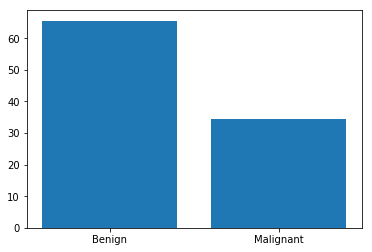

In [17]:
# Plot as a bar chart
plt.bar(range(len(outcome_freq['Percent'])), outcome_freq['Percent'], align='center')
plt.xticks(range(len(outcome_freq['Percent'])), list(outcome_freq.index))
plt.show()

## Visualize the Data

The data should be cleaned now and ready for preprocessing. Before doing preprocessing, let's visualize the distributions of data in each column, and the correlations between them.

### Correlations: Check for Collinearity

In [18]:
# check for correlations among features
df.corr()

,clump_thickness,uniformity_size,uniformity_shape,marg_adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
clump_thickness,1.000000,0.644913,0.654589,0.486356,0.521816,0.587300,0.558428,0.535835,0.350034,0.716001
uniformity_size,0.644913,1.000000,0.906882,0.705582,0.751799,0.686801,0.755721,0.722865,0.458693,0.817904
uniformity_shape,0.654589,0.906882,1.000000,0.683079,0.719668,0.709606,0.735948,0.719446,0.438911,0.818934
marg_adhesion,0.486356,0.705582,0.683079,1.000000,0.599599,0.665049,0.666715,0.603352,0.417633,0.696800
epithelial_size,0.521816,0.751799,0.719668,0.599599,1.000000,0.581261,0.616102,0.628881,0.479101,0.682785
bare_nuclei,0.587300,0.686801,0.709606,0.665049,0.581261,1.000000,0.675896,0.577362,0.338740,0.816050
bland_chromatin,0.558428,0.755721,0.735948,0.666715,0.616102,0.675896,1.000000,0.665878,0.344169,0.756616
normal_nucleoli,0.535835,0.722865,0.719446,0.603352,0.628881,0.577362,0.665878,1.000000,0.428336,0.712244
mitoses,0.350034,0.458693,0.438911,0.417633,0.479101,0.338740,0.344169,0.428336,1.000000,0.423170
class,0.716001,0.817904,0.818934,0.696800,0.682785,0.816050,0.756616,0.712244,0.423170,1.000000


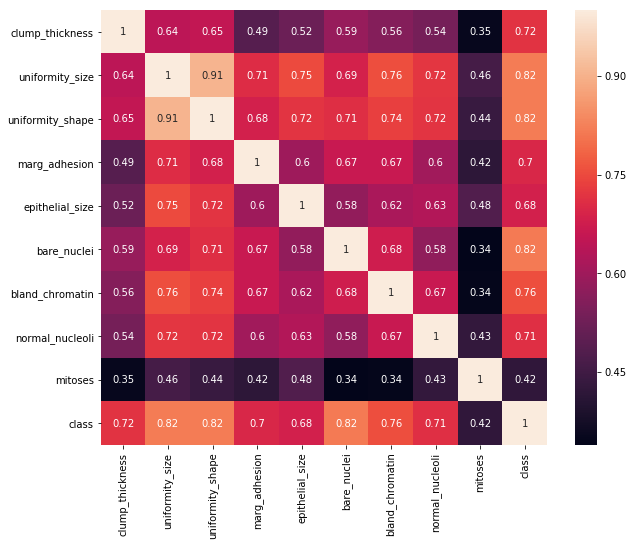

In [19]:
# plot correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True)

* Cell *size* uniformity is highly correlated with cell *shape* uniformity. To reduce collinearity, select one, drop the other.
* All other features have positive correlation with each other and with the outcome.
* Mitoses is the least correlated with the diagnosis.

In [20]:
# uniformity size and uniformity shape are highly correlated with each other - drop one?
df = df.drop(columns='uniformity_size')

In [21]:
# subset data frame into features and outcomes
features = df.loc[:, ['clump_thickness', 'uniformity_shape', 'marg_adhesion', 'epithelial_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses']]
outcomes = df['class'].values

In [22]:
df.head()

,clump_thickness,uniformity_shape,marg_adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,2,1.0,3,1,1,0
1,5,4,5,7,10.0,3,2,1,0
2,3,1,1,2,2.0,3,1,1,0
3,6,8,1,3,4.0,3,7,1,0
4,4,1,3,2,1.0,3,1,1,0


### Feature Distributions

Examine the distribution of each of the features. Observe lots of positive skew, suggesting we should transform the features. We will use the ```StandardScaler()``` from sklearn in preprocessing.

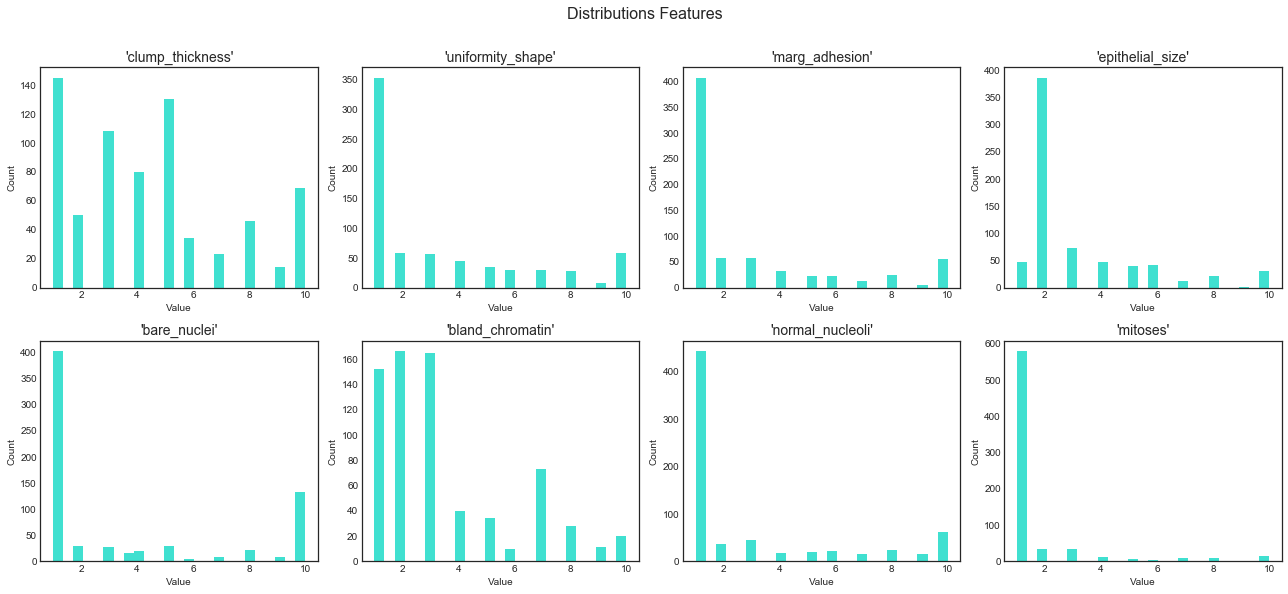

In [101]:
# Create figure
fig = plt.figure(figsize = (18,15));
plt.style.use('seaborn-white')

# Skewed feature plotting
for i, feature in enumerate(df.columns[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    ax.hist(df[feature], bins = 25, color = 'turquoise')
    ax.set_title("'%s'"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")

fig.suptitle("Distributions Features", \
            fontsize = 16, y = 1.03)

fig.tight_layout()
fig.show()

### Overlapping Density Plots

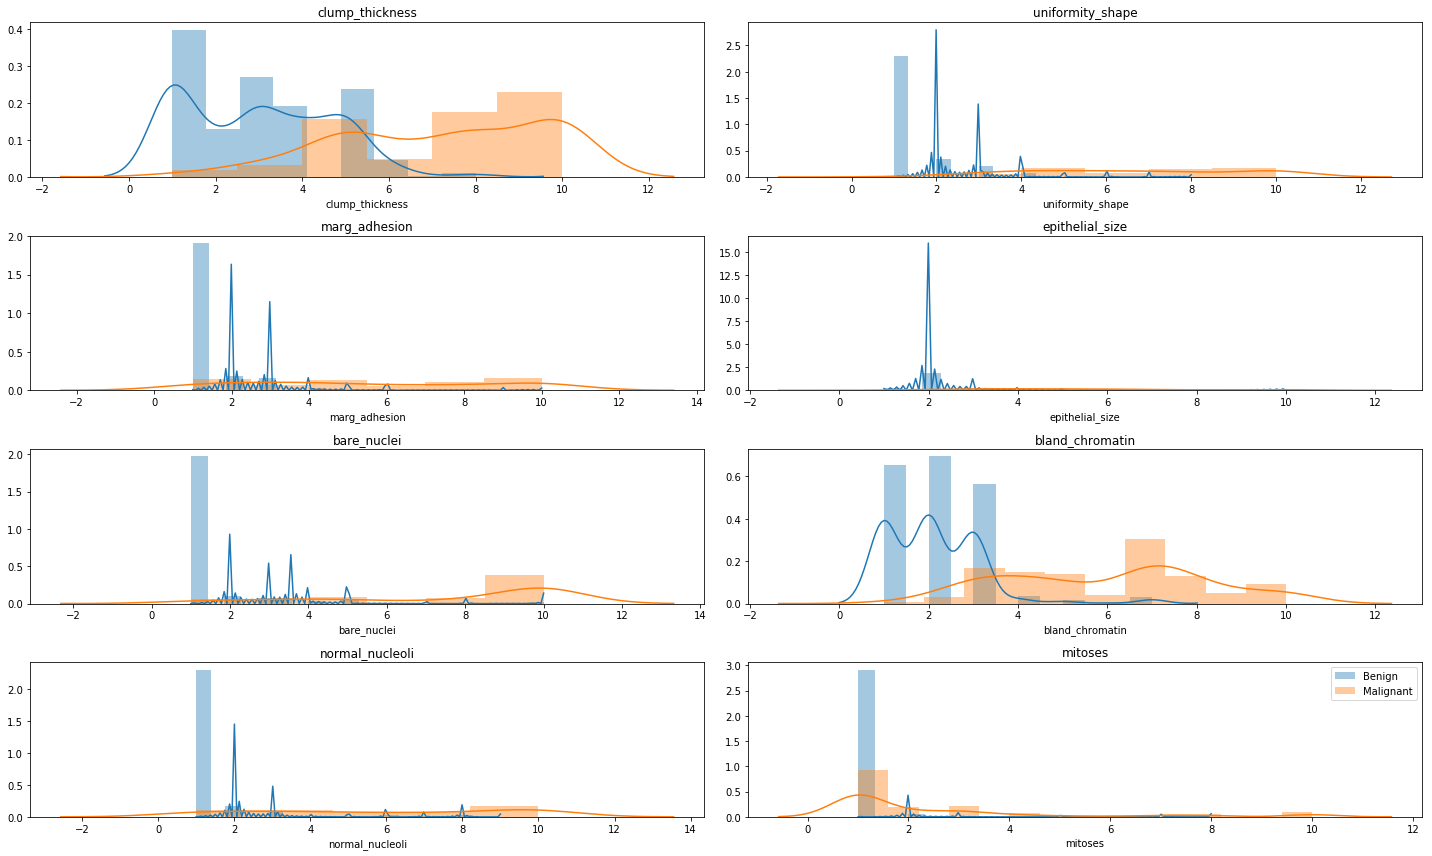

In [23]:
# subset dataframe by diagnosis
df_n = df[df['class'] == 0]
df_y = df[df['class'] == 1]

# create overlapping density plots
fig = plt.figure(figsize=(20,12))

# Loop through each feature and create hist
for i,x in enumerate(list(df.columns[0:8])):
    
    # need to add 1 for subplotting
    i +=1
    
    # Create object for each subplot
    ax = fig.add_subplot(4,2,i)
    
    # Plot distribution of each feature
    sns.distplot(df_n[x], kde=True, label='Benign')
    sns.distplot(df_y[x], kde=True, label='Malignant')
   
    ax.set_title(x)

plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# compare overlapping density plots
fig, axs = plt.subplots(nrows=8, figsize=(7,14))
for index, col_name in enumerate(features):
    df[col_name].groupby(df['class']).plot.kde(legend=True,ax=axs[index])
    axs[index].set_title(col_name)
plt.tight_layout()

### Overlapping Histogram Plots

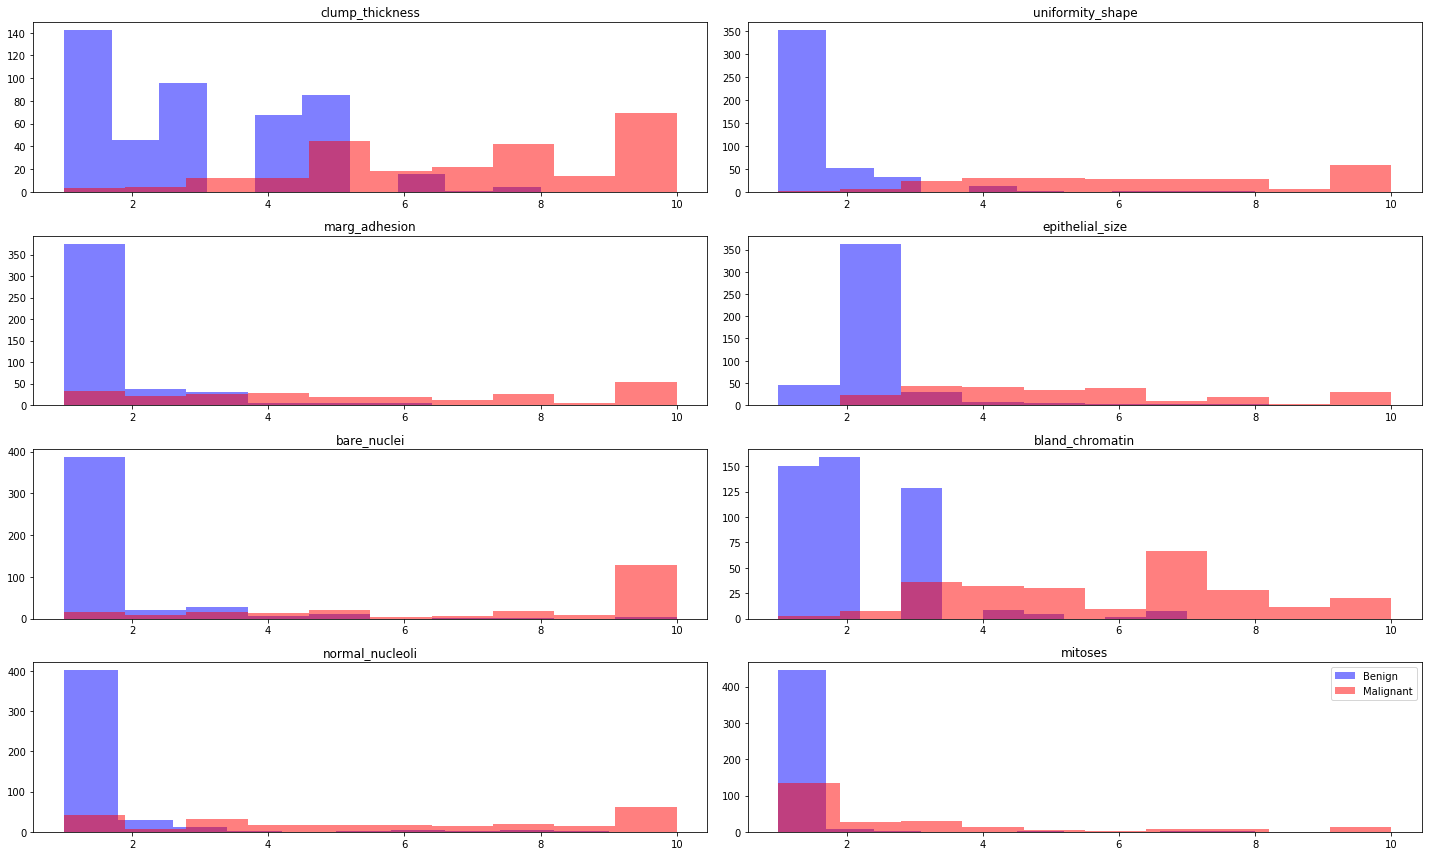

In [24]:
# create histogram plots
fig = plt.figure(figsize=(20,12))

# Loop through each feature and create hist
for i,x in enumerate(list(df.columns[0:8])):
    
    # need to add 1 for subplotting
    i +=1
    
    # Create object for each subplot
    ax = fig.add_subplot(4,2,i)
    
    # Plot distribution of each feature
    ax.hist(df_n[x], label = 'Benign', stacked = True, alpha=0.5, color= 'b')
    ax.hist(df_y[x], label= 'Malignant', stacked = True, alpha=0.5, color= 'r')
   
    ax.set_title(x)

plt.tight_layout()
plt.legend()
plt.show()

There seem to be clear differences between benign and malignant samples for many of these features, so hopefully we will be able to get good results with a binary classifier! In fact, 'mitoses' looks like the only one without much discriminatory power - but we'll see what happens we get to the actual classification.

## Dimensionality Reduction

We may want to consider transforming our features using a dimensionality reduction method.

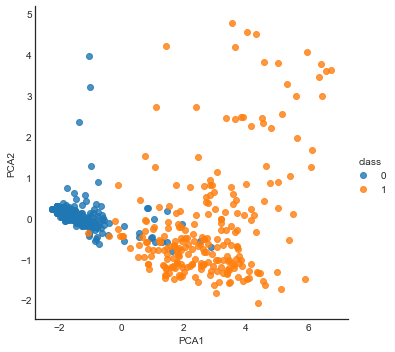

In [105]:
# Technique 1: PCA
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=3)            # 2. Instantiate the model with hyperparameters
model.fit(features)                    # 3. Fit to data. Notice the class variable is not specified!
X_3D = model.transform(features)    

import copy
df_explore = copy.deepcopy(df)
df_explore['PCA1'] = X_3D[:, 0]
df_explore['PCA2'] = X_3D[:, 1]
df_explore['PCA3'] = X_3D[:, 2]
sns.lmplot("PCA1", "PCA2", hue='class', data=df_explore, fit_reg=False);

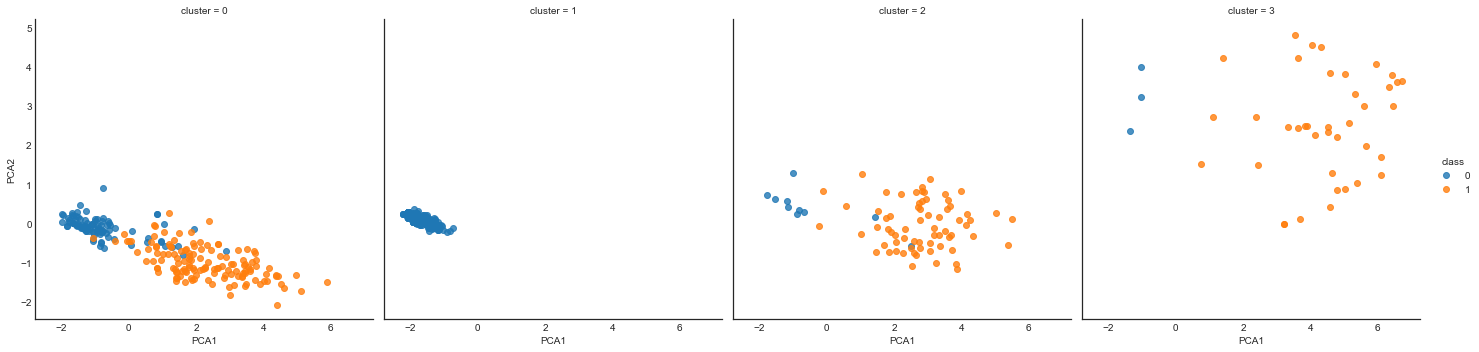

In [106]:
# Technique 2: Gaussian Mixture Model
from sklearn.mixture import GMM      # 1. Choose the model class
model = GMM(n_components=4,
            covariance_type='full')  # 2. Instantiate the model with hyperparameters
model.fit(features)                  # 3. Fit to data. Notice y is not specified!
y_gmm = model.predict(features)    

df_explore['cluster'] = y_gmm
sns.lmplot("PCA1", "PCA2", data=df_explore, hue='class',
           col='cluster', fit_reg=False);

These plots suggest that a technique like PCA will likely over-simplify our classifier. These methods do not do a good job of separating in cluster 1, which could yield false positives and negatives. For this reason, we will not use PCA.

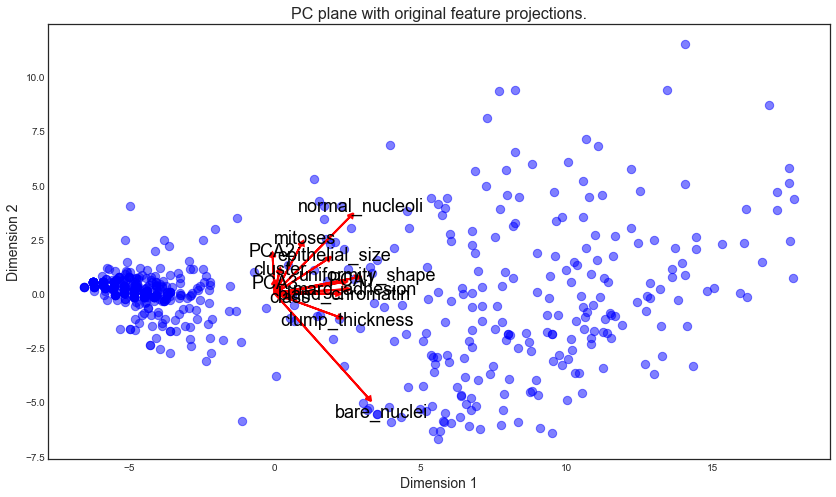

In [108]:
# creating a biplot

pca = PCA(n_components=2).fit(df_explore)
reduced_data = pca.transform(df_explore)
pca_samples = pca.transform(df_explore)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
def biplot(data, reduced_data, pca):
    
    fig, ax = plt.subplots(figsize = (14,8))
    
    # scatterplot of the reduced data 
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # using scaling factors to make the arrows
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

biplot(df_explore, reduced_data, pca)

## Sampling Method

As noted earlier, we have a case of **imbalanced classes** (fewer cancerous than benign). Given this, we should either select a model that is robust to imbalanced classes, or employ a sampling method. Here, we will use SMOTE to upsample and balance classes.

In [113]:
from imblearn.over_sampling import SMOTE

print("Number in X_train dataset: ", X_train.shape)
print("Number in y_train dataset: ", y_train.shape)
print("Number in X_test dataset: ", X_test.shape)
print("Number in y_test dataset: ", y_test.shape)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Number in X_train dataset:  (559, 8)
Number in y_train dataset:  (559,)
Number in X_test dataset:  (140, 8)
Number in y_test dataset:  (140,)
Before OverSampling, counts of label '1': 193
Before OverSampling, counts of label '0': 366 

After OverSampling, the shape of train_X: (732, 8)
After OverSampling, the shape of train_y: (732,) 

After OverSampling, counts of label '1': 366
After OverSampling, counts of label '0': 366


## Models

### Model Preprocessing

For preprocessing, we will employ the ```StandardScaler()``` since these data are all numeric and reasonably well-behaved in terms of their distribution over the range 1-10. The ```StandardScaler()``` divides X by the mean and scales by the standard deviation for each feature. This makes it much faster to train a classification algorithm on the data. 

In [25]:
# scale features
from sklearn.preprocessing import StandardScaler  

features = StandardScaler().fit_transform(features)

We will now split the data into training and test sets, with 80% of the data going into training.

In [26]:
# create training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, outcomes, stratify=outcomes, 
                                                    random_state=15, test_size=0.2)

### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print('Accuracy on training data: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on test data: {:.3f}'.format(log_reg.score(X_test,y_test)))

Accuracy on training data: 0.966
Accuracy on test data: 0.979


Logistic Regression results:
* Easy to interpret
* Accuracy is high, but could probably improve with a different method or selecting different features

### K-Nearest Neighbors Classification

Accuracy on the training data: 0.966
Accuracy on the testing data: 0.971


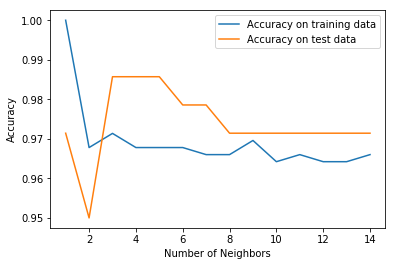

In [29]:
from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
test_accuracy = []

# try from k= 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train,y_train)
    training_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy on training data')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy on test data')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

print('Accuracy on the training data: {:.3f}'.format(knn.score(X_train,y_train)))
print('Accuracy on the testing data: {:.3f}'.format(knn.score(X_test,y_test)))

K Nearest Neighbors results summary:
* Best result at ```k = 4```
* Results slightly better than logistic regression for test data, slightly lower accuracy for training data

### Support Vector Classifier

Next I will consider linear SVM. SVM is optimized for finding decision boundaries. It can run a little slower than logistic regression, but in this case the dataset is relatively small (N = 699) and has relatively few features (n = 9), so performance will not be an issue.

The specific implementation of linear SVM I use is the ```SGDClassifier```, which uses stochastic gradient descent for the learning rate and l2 regularization to help with overfitting. I will check the accuracy using stratified k-fold cross validation with ```k=10``` folds. 

In [28]:
# SVM linear classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=10, random_state=42)
sgd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
print('accuracy on training set: %2f' % cross_val_score(sgd_clf, X_train, y_train, cv=10, scoring="accuracy").mean())
print('accuracy on test set: %2f ' % cross_val_score(sgd_clf, X_test, y_test, cv=10, scoring="accuracy").mean())

accuracy on training set: 0.962270
accuracy on test set: 0.970879 


This runs in less than a second and has a mean accuracy of ```96.2%``` on the training set and ```97.1%``` on the test set! This is already pretty good. Surprisingly, we do a little better on the test set than the training set. This is probably down to random luck, but it does show that we are not overfitting the data, which is good news. 

We should now check the ```confusion matrix``` and compute the ```precision``` and ```recall``` to see what type of errors might be cropping up.

In [39]:
# confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_test_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=10)
confusion_matrix(y_test, y_test_pred)

array([[91,  1],
       [ 3, 45]])

We have 1 ```false positives``` and 3 ```false negatives```, so our classifier is about equally good at both precision and recall. Let's compute the exact values for these, as well as the standard ```F1 score```. 

In [38]:
# classification report
from sklearn.metrics import classification_report

y_test_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=10)
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98        92
          1       0.98      0.94      0.96        48

avg / total       0.97      0.97      0.97       140



We can delve deeper by looking at the ```feature importance``` in the model (scaled so their sum adds to 1). For the SGD classifier, ```clump_thickness_``` is the most important feature.

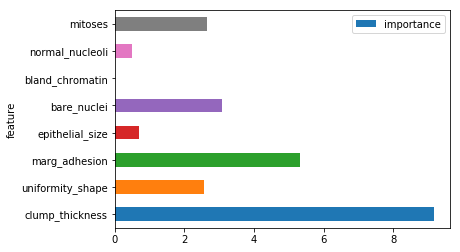

In [97]:
svc_feat = pd.DataFrame({'feature':list(df_feat.columns.values),'importance': sgd_clf.coef_[0]})
ax = svc_feat.plot.barh(x='feature', y='importance')

The F1 score is ```0.97```. This is pretty good, but having a ```3%``` chance of missing a malignant tumor can cost lives, so let's try to do a bit better. 

### Random Forests

As an alternative to SVM, we can also consider ```Random Forest Classification```, which may produce better results. A RF model can take longer to run on large datasets and is a bit more of a "black box", but for ```n=8``` features it still should be pretty quick. As a decision tree method, it creates new decision boundaries as needed to fit the data, but naturally guards against overfitting via out-of-bag validation.

In [44]:
# Random forest classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=15)
forest_clf.fit(X_train, y_train)
print('accuracy on training set: %2f' % cross_val_score(forest_clf, X_train, y_train, cv=10, scoring="accuracy").mean())
print('accuracy on test set: %2f ' % cross_val_score(forest_clf, X_test, y_test, cv=10, scoring="accuracy").mean())

accuracy on training set: 0.960451
accuracy on test set: 0.985165 


In [49]:
# classification report
y_train_pred_forest = cross_val_predict(forest_clf, X_test, y_test, cv=10)
print(classification_report(y_test, y_train_pred_forest))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99        92
          1       0.98      0.98      0.98        48

avg / total       0.99      0.99      0.99       140



The random forest classifier is a bit of a black box, but we can at least get a sense of what it is doing by printing the ```feature importance``` (scaled so their sum adds to 1). The most important feature, by far, is ```uniformity_shape```, while ```mitoses``` is the least important, as I predicted it would be!

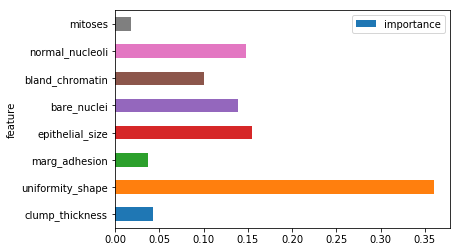

In [93]:
feat_df = pd.DataFrame({'feature':list(df_feat.columns.values),'importance': forest_clf.feature_importances_})
fax = feat_df.plot.barh(x='feature', y='importance')

## Model Optimization

We have a functional classifier now. To optimize the clasifier, I will now go through different choices of the hyperparameters for the SVM and Random Forest classifiers, and see if we can improve the F1 scores and the recall. 

Let's start with SVM, this time using the SVC classifier instead of the SGDClassifier, since it gives better control over hyperparameters. We can test both a ```linear``` and an ```rbf kernel```, and vary the size of the ```error term``` C from 0.0001 to 1000. 

In [80]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

hyper_parameters = {'kernel':('linear', 'rbf'), 'C':[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]}
svc = SVC(random_state=15)
grid_search = GridSearchCV(svc, hyper_parameters)
grid_search.fit(X_train, y_train)
print('best SVM hyperparameters: '+str(grid_search.best_params_))
print('accuracy of SVM with these hyperparameters: %2f' % grid_search.best_score_)

best SVM hyperparameters: {'C': 0.1, 'kernel': 'linear'}
accuracy of SVM with these hyperparameters: 0.966011


The SVM model with the highest accuracy is linear SVM with ```C=0.1```, so let's check the check the cross-validation accuracy, as well as the precision, recall, and F1 score for this model.

In [85]:
svc_best = SVC(kernel='linear', C=0.1, random_state=15)
svc_best.fit(X_train, y_train)
print('accuracy on test set: %2f ' % cross_val_score(svc_best, X_test, y_test, cv=10, scoring="accuracy").mean())

accuracy on test set: 0.970879 


In [86]:
y_test_pred_svc_best = cross_val_predict(svc_best, X_test, y_test, cv=10)
print(classification_report(y_test, y_test_pred_svc_best))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98        92
          1       0.98      0.94      0.96        48

avg / total       0.97      0.97      0.97       140



This SVM model performs similar to the one we considered previously, and has high accuracy and pretty good precision and recall. 

Let's do a ```grid search``` of random forest ```hyperparameters``` before picking the best final classifier. This grid takes a little while to search (~3 minutes on my laptop). Let's see how the result looks:

In [88]:
hyper_parameters = {'n_estimators':(10, 30, 100, 300, 1000), 'criterion':('gini', 'entropy'), 'max_features':('auto',3,4,5,6,7)}
rfc = RandomForestClassifier(random_state=15)
grid_search = GridSearchCV(rfc, hyper_parameters)
grid_search.fit(X_train, y_train)
print('best Random Forest hyperparameters: '+str(grid_search.best_params_))
print('accuracy of Random Forest with these hyperparameters: %2f' % grid_search.best_score_)

best Random Forest hyperparameters: {'criterion': 'entropy', 'max_features': 3, 'n_estimators': 30}
accuracy of Random Forest with these hyperparameters: 0.967800


In [89]:
rfc_best = RandomForestClassifier(criterion='entropy', max_features='auto', n_estimators=300, random_state=42)
rfc_best.fit(X_train, y_train)
print('accuracy on test set: %2f ' % cross_val_score(rfc_best, X_test, y_test, cv=10, scoring="accuracy").mean())

accuracy on test set: 0.978022 


In [90]:
y_test_pred_rfc_best = cross_val_predict(rfc_best, X_test, y_test, cv=10)
print(classification_report(y_test, y_test_pred_rfc_best))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98        92
          1       0.98      0.96      0.97        48

avg / total       0.98      0.98      0.98       140



The RFC we found via the grid search is our best model!